In [1]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 5fd22109-7e01-4065-9ca2-9a71dffe7c8e

In [2]:
import Local_NAV as local
from Global_NAV import *
import Motion_CTR_ as mctrl
import Kalman_FIL as kfil
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import IPython
from IPython.display import display, clear_output
import time

from matplotlib import colors
from cvision import *

%matplotlib inline

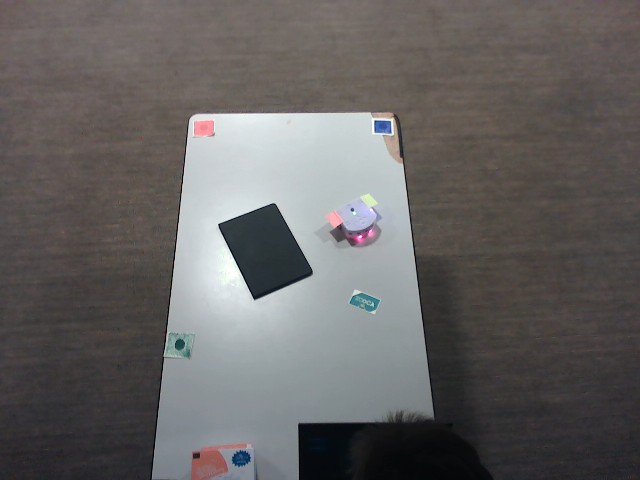

In [3]:
#Global variables
state = 0
obst = [0,0,0,0,0]
motors_speed = [0,0]
not_arrived = True
k = 0
C_conv_toThymio_right = 67.60908181
C_conv_toThymio_left = 67.82946137
L = 104
R = 20
Ts = 0.02 # sampling time
# Initial state covariance matrix
P_k_minus_1 = np.array([[0.1, 0, 0],
                        [0, 0.1, 0],
                        [0, 0, 0.1]])
P_k = P_k_minus_1
threshold_for_convergence = 50

path = []
while True:
    if state == 0:
        # Definition of the references used to map the space
        color_ref1 = cv2.imread('ref1.jpg')
        ref1 = Obj(color_ref1, 50, 2, np.array([[0,0]]))
        color_ref2 = cv2.imread('ref2.jpg')
        ref2 = Obj(color_ref2, 100, 2, np.array([[0,0]]))
        color_ref3 = cv2.imread('ref3.jpg')
        ref3 = Obj(color_ref3, 100, 2, np.array([[0,0]]))
        map = Map(ref1, ref2, ref3)

        # Definition of the objects to recognize in the space
        color_obstacle = cv2.imread('obstacle.jpg')
        obstacle = Obj(color_obstacle, 700, 4)
        color_goal = cv2.imread('goal.jpg')
        goal = Obj(color_goal, 100, 4)
        color_left_mark = cv2.imread('left_mark.jpg')
        left_mark = Obj(color_left_mark, 50, 2)
        color_right_mark = cv2.imread('right_mark.jpg')
        right_mark = Obj(color_right_mark, 50, 2)
        thymio = Robot(right_mark, left_mark)

        # Open the video
        # For a livestream
        video = cv2.VideoCapture(0)
        # or with a prerecorded video
        #video = cv2.VideoCapture('test3.avi')
        if (video.isOpened()== False): 
            print("Error opening video stream or file")
        
        # Recognition of the view with the map and path planning
        path_found = False
        while not (path_found):
            ret, frame = video.read()
            if ret == True:
                matrix = map.matrix(frame, [obstacle], thymio, goal)
                show_frame(frame)
                if check_matrix(matrix):
                    path = global_path(matrix)
                    N = len(path)
                    path_found = True
                    print('Path :', path)
                    max_val_x, max_val_y, start, end, arr = conversion(matrix)
                    h, coords = heuristics(max_val_x, max_val_y, end)
                    path, visitedNodes = A_Star(start, end, h, coords, arr)
                    path = np.array(path).reshape(-1, 2).transpose()
                    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
                    cmap = colors.ListedColormap(['white', 'red'])
                    # Displaying the map
                    fig_astar, ax_astar = create_empty_plot(max_val_x, max_val_y)
                    ax_astar.imshow(arr.transpose(), cmap)

                    # Plot the best path found and the list of visited nodes
                    ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange')
                    ax_astar.plot(path[0], path[1], marker="o", color = 'blue')
                    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200)
                    ax_astar.scatter(end[0], end[1], marker="o", color = 'purple', s=200)
                    plt.title("best path in blue, visited nodes in orange")
                    plt.title("Map : free cells in white, occupied cells in red")
                    plt.show()
                    print('Robot position : ', thymio.localize(frame,map)[0])
                    print('Robot direction : ', vector_to_angle(thymio.localize(frame,map)[1]))
                    state_estimate_k = np.array([thymio.localize(frame,map)[0,0],thymio.localize(frame,map)[0,1],vector_to_angle(thymio.localize(frame,map)[1])])
                clear_output(wait=True) 

        # Navigation
        state = 1    
        # Global navigation state
        if state == 1:

            while not_arrived == True:
                #Check if there is obstacles
                prox_horizontal = local.read_prox_sensors(node,client)
                obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
                state = local.update_state(state,obst,client)

                # Update temporary goal

                if k < N-1:
                    theta_goal_temp = (math.atan2(path[0,k+1]-path[0,k], path[1,k+1]-path[1,k]) + np.pi) % (np.pi/2) - np.pi
                v, w = mctrl.control_law(state_estimate_k, path[0,k], path[1,k], theta_goal_temp)
                vr, vl = mctrl.convert_velocity2RL(v,w,C_conv_toThymio_right, C_conv_toThymio_left,L,R)
                vr = int(vr)
                vl = int(vl)
                mctrl.set_motors(vl,vr,node)
                
                camera_obstructed = 1
                # Check if camera is obstructed
                if video.isOpened:
                    ret, frame = video.read()
                    if ret == True:
                        if np.size(thymio.localize(frame,map)[1], 0) > 0:
                            camera_obstructed = 0
                            #clear_output(wait=True)
                            #print('Path :', path)
                            #print('Robot position : ', thymio.localize(frame,map)[0])
                            #print('Robot direction : ', vector_to_angle(thymio.localize(frame,map)[1]))
                            z_k_observation_vector = np.array([thymio.localize(frame,map)[0][0],thymio.localize(frame,map)[0][1],vector_to_angle(thymio.localize(frame,map)[1])]) 
                            P_k_minus_1 = P_k
                            state_estimate_k,P_k = kfil.ekf(z_k_observation_vector, state_estimate_k, [v,w] , P_k_minus_1, Ts, camera_obstructed)
                        else:
                            z_k_observation_vector = np.array([state_estimate_k[0], state_estimate_k[1], state_estimate_k[2]])
                            state_estimate_k,P_k = kfil.ekf(z_k_observation_vector, state_estimate_k, [v,w] , P_k_minus_1, Ts, camera_obstructed)

                if np.linalg.norm(state_estimate_k[:2] - np.array([path[0,k], path[1,k]])) < threshold_for_convergence:
                    k = k+1
                    if k == N-1:
                        not_arrived = False
                        print('The robot has arrived to the final goal')
                    break 
                time.sleep(Ts)
            state = 3                                               


        # Local navigation state
        if state == 2: 
            
            #We get the sensor value
            prox_horizontal = local.read_prox_sensors(node,client)
            
            #We fill the obst list with the sensor value
            obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
            
            #We calculate the motor speed to avoid the object -> potential field method
            motors_speed = local.local_navigation(obst)
            
            #We set the motor speed
            mctrl.set_motors(motors_speed[0],motors_speed[1],node)       
            
            #We update the state
            state = local.update_state(state,obst,client)   


In [15]:
motors_speed = local.global_path()
local.set_motors(motors_speed[0],motors_speed[1],node) 
local.stop_motors(node) 


AttributeError: module 'Local_NAV' has no attribute 'global_path'

In [8]:
mctrl.stop_motors(node)